In [1]:
import pandas as pd
import numpy as np
import random
import gzip

# MNIST preprocessing to tabular data
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    df = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    digit_label = np.frombuffer(f.read(), np.uint8, offset=8)

df = pd.DataFrame(df)
df['target'] = digit_label
df.target = np.where(df.target == 7, 1, 0)

size = sum(df.target == 1)
index_set_0 = df.loc[df.target == 0].index.tolist()
index_set_1 = df.loc[df.target == 1].index.tolist()
random.seed(1201)
sample_index_0 = list(random.sample(index_set_0, size))
sample_index_1 = list(random.sample(index_set_1, round(size/10)))
total_index =  sample_index_1 + sample_index_0

df = df.iloc[total_index, :].reset_index(drop=True)

df.target.value_counts()

0    6265
1     626
Name: target, dtype: int64

In [2]:
def kfold(data, fold, seed):
    import random
    idx_set_1 = data.loc[data.target== 1].index.tolist()
    idx_set_0 = data.loc[data.target == 0].index.tolist()
    size_1 = round(len(idx_set_1)/fold)
    size_0 = round(len(idx_set_0)/fold)
    folded_idx_set = []
    for i in range(fold):
        if (i == fold-1):
            folded_idx_set.append(idx_set_1+idx_set_0)
        else:
            random.seed(seed)   
            folded_idx_set.append(list(random.sample(idx_set_1, size_1))+list(random.sample(idx_set_0, size_0)))
            idx_set_1 = list(set(idx_set_1)-set(folded_idx_set[len(folded_idx_set)-1]))
            idx_set_0 = list(set(idx_set_0)-set(folded_idx_set[len(folded_idx_set)-1]))
    
    return folded_idx_set

kfold_idx_set = kfold(data=df, fold=5, seed=1201)

trn_X = []
trn_y = []
tst_X = []
tst_y = []
index_set = df.index.tolist()

for i in range(5):
    total_idx = set(index_set)
    trn_X.append(df.loc[list(total_idx-set(kfold_idx_set[i])), list(range(0,784))])
    trn_y.append(df.loc[list(total_idx-set(kfold_idx_set[i])), 'target'])
    tst_X.append(df.loc[kfold_idx_set[i], list(range(0,784))])
    tst_y.append(df.loc[kfold_idx_set[i]]['target'])

In [6]:
from sklearn.metrics import confusion_matrix
def evaluation(model, X, y):
    y_pred = model.predict(X)

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    return [tp/(fn+tp), tn/(fp+tn), tp/(fp+tp), 2*tp/(fp+2*tp+fn)]

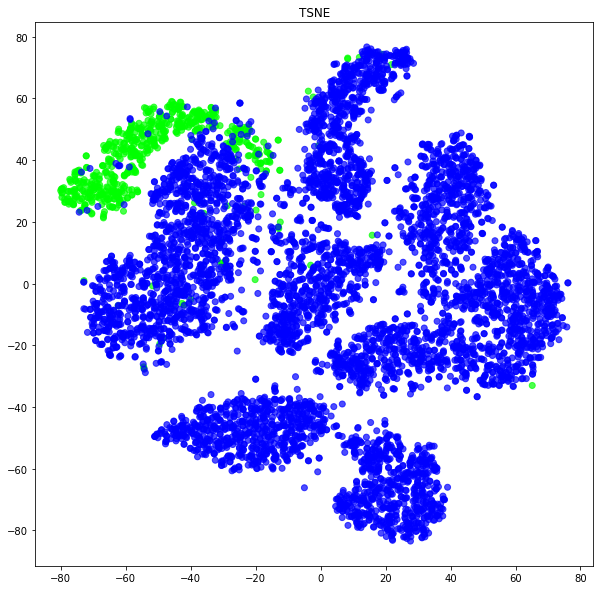

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") # warning 무시

tsne = TSNE(n_components=2, random_state = 1201)
tsne_data = tsne.fit_transform(df[list(range(0,784))])
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])

plt.figure(figsize=(10,10))
plt.title('TSNE')
plt.scatter(tsne_data.z1, tsne_data.z2, c=df.target, cmap=plt.cm.brg, alpha=0.7)

# RBF SVM

In [9]:
from sklearn.svm import SVC
import time

eval_data = []
for fold_num in range(5):
    st = time.time()
    model = SVC(kernel='rbf', C=10, gamma=0.03)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    tt = time.time() - st
    eval_data.append([fold_num+1, tt] + evaluation(model, tst_X[fold_num], tst_y[fold_num]))

eval_data = pd.DataFrame(eval_data, columns=['fold', 'time', 'TPR', 'TNR', 'precision', 'f1'])

eval_data.to_csv('SVM_evaldf.csv', index=False)

# bagging

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import time

In [11]:
base_learner_list = [DecisionTreeClassifier(), SVC()]
for i in range(1, 6):
    for j in range(2):
        eval_data = []
        for fold_num in tqdm(range(5)):
            base_learner = base_learner_list[j]
            st = time.time()
            model = BaggingClassifier(base_estimator=base_learner, n_estimators=100*i, random_state=1201, n_jobs=8)
            model.fit(trn_X[fold_num], trn_y[fold_num])
            tt = time.time() - st

            eval_data.append([fold_num+1, tt] + evaluation(model, tst_X[fold_num], tst_y[fold_num]))
        
        eval_data = pd.DataFrame(eval_data, columns=['fold', 'time', 'TPR', 'TNR', 'precision', 'f1'])
        if j ==0 :
            eval_data.to_csv('bagging_DT_evaldf_'+str(i)+'.csv', index=False)
        else:
            eval_data.to_csv('bagging_SVM_evaldf_'+str(i)+'.csv', index=False)

100%|██████████| 5/5 [12:22<00:00, 148.51s/it]


# random forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
for i in range(1,6):
    eval_data = []
    for fold_num in range(5):
        st = time.time()
        model = RandomForestClassifier(n_estimators = 100*i, oob_score=True, n_jobs = 8)
        model.fit(trn_X[fold_num], trn_y[fold_num])


        tt = time.time() - st
        eval_data.append([fold_num+1, tt] + evaluation(model, tst_X[fold_num], tst_y[fold_num]))

    eval_data = pd.DataFrame(eval_data, columns=['fold', 'time', 'TPR', 'TNR', 'precision', 'f1'])

    eval_data.to_csv('RF_evaldf_'+str(i)+'.csv', index=False)